# Noisy Labels and Label Smoothing

When we apply the cross-entropy loss to a classification task, we're expecting true labels to have 1, while the others 0. In other words, we have no doubts that the true labels are true, and the others are not. Is that always true? Maybe not. Many manual annotations are the results of multiple participants. They might have different criteria. They might make some mistakes. They are human, after all. As a result, the ground truth labels we have had perfect beliefs on are possible wrong. <p>
One possibile solution to this is to relax our confidence on the labels. For instance, we can slighly lower the loss target values from 1 to, say, 0.9. And naturally we increase the target value of 0 for the others slightly as such. This idea is called label smoothing. Consult [this](https://arxiv.org/abs/1512.00567) for more information.<p>
In this short project, I examine the effects of label smoothing when there're some noise. Concretly, I'd like to see if label smoothing is effective in a binary classification/labeling task where both labels are noisy or only one label is noisy.

kyubyong park.
https://github.com/kyubyong/label_smoothing

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.__version__

'1.3.0'

# Data design

Let's create a simple synthetic data. We make a bunch of integer sequences that are 10 in length whose elements are either 0, 1, or 2. And we label each of them as follows:<br>
  * if an element is preceded by 0, its label goes to 1.
  * 0, otherwise.

In [2]:
np.random.seed(0) # for reproducibility

X = np.random.randint(0, 3, (32*1100, 10), np.int32) # inputs
Y = np.equal(np.concatenate((np.ones_like(X[:, :1]), np.sign(X[:, :-1])), 1), 0).astype(np.int32) # labels

# Split them into training and validation data.
X_train, X_test = np.split(X, [32*1000], axis=0)
Y_train, Y_test = np.split(Y, [32*1000], axis=0)

Let's see what the generated data look like.

In [4]:
print(X_train[0])
print(Y_train[0])

[0 1 0 1 1 2 0 2 0 0]
[0 1 0 1 0 0 0 1 0 1]


# Main Function

Now we're going to write a function to manipulate the value of Y_train and target values of the loss function.

In [4]:
def run(noise_rates=[0., 0.], confidence_rates=[1., 1.]):
    '''corruption rates: A list of two floating numbers. 
    If a corruption rate is 0, label can be corrupted.'''
    
    # Corruption
    chances = np.random.uniform(size=(32*1000, 10))
    condlist = [np.logical_and(Y_train==0, chances>=noise_rates[0]), 
                np.logical_and(Y_train==0, chances<noise_rates[0]),
                np.logical_and(Y_train==1, chances>=noise_rates[1]),
                np.logical_and(Y_train==1, chances<noise_rates[1])]
    choicelist = [0, 1, 1, 0]
    Z_train = np.select(condlist, choicelist)
    
    # Graph
    tf.reset_default_graph()
    
    # Mini batches
    x = tf.placeholder(tf.int32, (32, 10), name="x")
    y = tf.placeholder(tf.int32, (32, 10), name="true_label")
    z = tf.placeholder(tf.int32, (32, 10), name="noisy_label")

    inputs = tf.one_hot(x, 3)
    
    # Label smoothing
    cr0, cr1 = confidence_rates
    table = tf.convert_to_tensor(
                [[cr0, 1.-cr0], 
                 [1.-cr1, cr1]])

    labels = tf.nn.embedding_lookup(table, z)

    # network
    cell = tf.nn.rnn_cell.GRUCell(100)
    outputs, _  = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)
    logits = tf.layers.dense(outputs, 2)
    preds = tf.argmax(logits, -1, output_type=tf.int32)

    # metric
    hits = tf.reduce_sum(tf.to_float(tf.equal(preds, y))) # <- metric should be computed from true labels.
    acc = hits / tf.to_float(tf.size(x))

    # Loss and training
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    loss = tf.reduce_mean(loss)

    global_step = tf.Variable(0, name='global_step', trainable=False)
    optimizer = tf.train.AdamOptimizer(0.001)
    train_op = optimizer.minimize(loss, global_step=global_step)
    
    # Session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        global_steps, losses, val_accs, cr0s, cr1s = [], [], [], [], []
        stop_msg = False
        for i in range(0, 32*1000, 32):
            _x = X_train[i:i+32]
            _y = Y_train[i:i+32]
            _z = Z_train[i:i+32]
        
            _, gs, _loss = sess.run([train_op, global_step, loss], 
                                    {x: _x, y: _y, z:_z})     
            losses.append(_loss)
            
            if gs % 10 == 0:
                total_hits = 0
                for j in range(0, 32*100, 32):
                    x_ = X_test[j:j+32]
                    y_ = Y_test[j:j+32] 
                    total_hits += sess.run(hits, {x: x_, y: y_, z:_z})
                val_acc = total_hits / float(X_test.size)
                val_accs.append(val_acc)
                global_steps.append(gs)
                if not stop_msg and val_acc==1.: 
                    print("\x1b[31mAter {} global steps, the validation accuracy reached 1.\x1b[0m".format(gs))
                    stop_msg=True
        # Plot
        plt.plot(losses, label="training loss")
        plt.plot(global_steps, val_accs, label="validation accuracy")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.title("noise rates=[{}, {}], \nconfidence rates=[{}, {}]".format(
                    noise_rates[0], noise_rates[1], confidence_rates[0], confidence_rates[1]))
        plt.grid()
        plt.show()
        
        

# \#1. Increase the noise rates by .1 without label smoothing.

Ater 100 global steps, the validation accuracy reached 1.


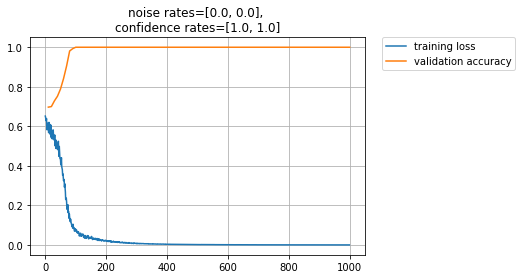

In [5]:
run(noise_rates=[0., 0.], confidence_rates=[1., 1.])

Ater 100 global steps, the validation accuracy reached 1.


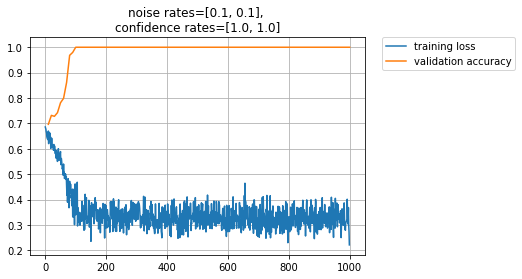

In [6]:
run(noise_rates=[.1, .1], confidence_rates=[1., 1.])

Ater 110 global steps, the validation accuracy reached 1.


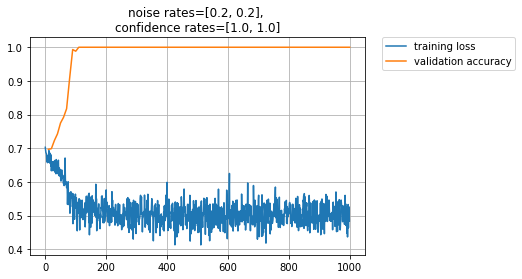

In [7]:
run(noise_rates=[.2, .2], confidence_rates=[1., 1.])

Ater 120 global steps, the validation accuracy reached 1.


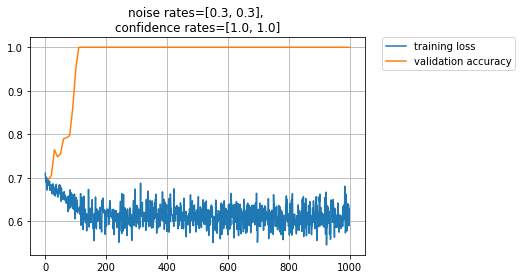

In [8]:
run(noise_rates=[.3, .3], confidence_rates=[1., 1.])

Ater 150 global steps, the validation accuracy reached 1.


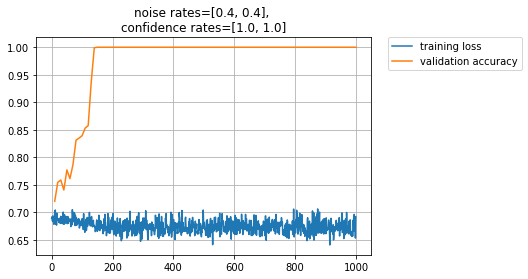

In [9]:
run(noise_rates=[.4, .4], confidence_rates=[1., 1.])

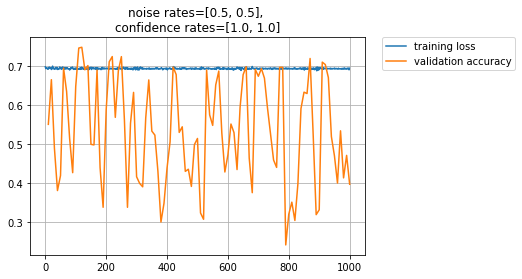

In [10]:
run(noise_rates=[.5, .5], confidence_rates=[1., 1.])

▴ Result: If there's noise in both labels, the training loss gets higher and it takes longer until the validation result converges. 

# \#2. Decrease the confidence rates by .1 without label noises.

Ater 100 global steps, the validation accuracy reached 1.


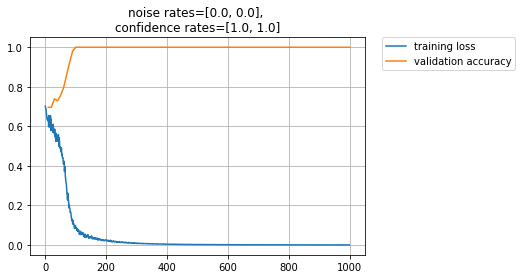

In [11]:
run(noise_rates=[.0, .0], confidence_rates=[1., 1.])

Ater 90 global steps, the validation accuracy reached 1.


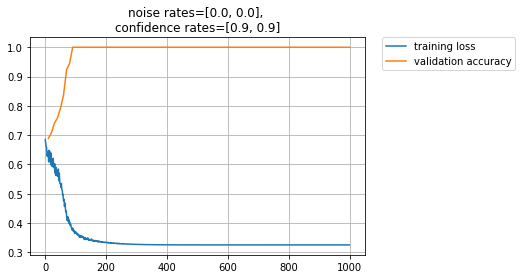

In [12]:
run(noise_rates=[.0, .0], confidence_rates=[.9, .9])

Ater 90 global steps, the validation accuracy reached 1.


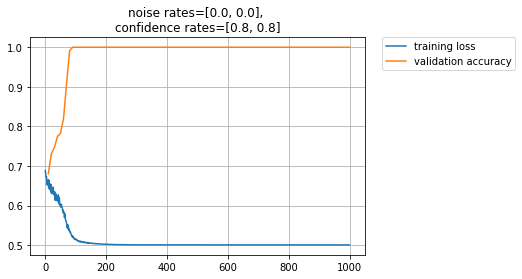

In [13]:
run(noise_rates=[.0, .0], confidence_rates=[.8, .8])

Ater 80 global steps, the validation accuracy reached 1.


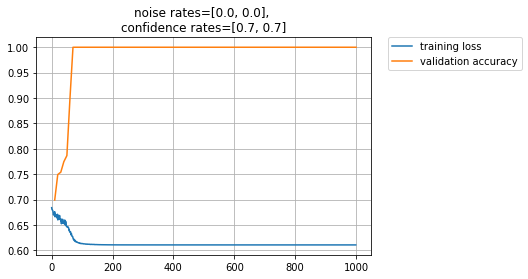

In [14]:
run(noise_rates=[.0, .0], confidence_rates=[.7, .7])

Ater 90 global steps, the validation accuracy reached 1.


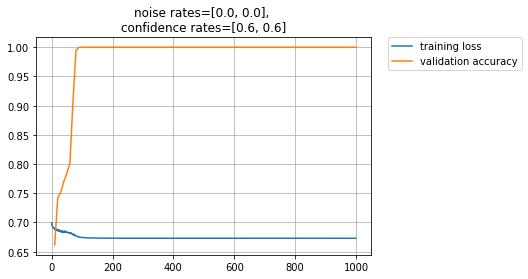

In [15]:
run(noise_rates=[.0, .0], confidence_rates=[.6, .6])

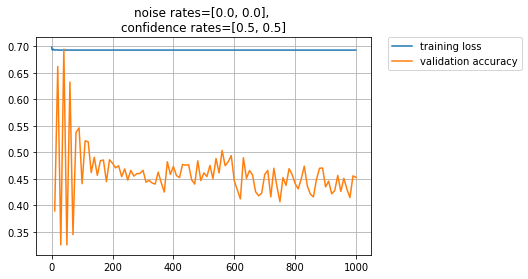

In [16]:
run(noise_rates=[.0, .0], confidence_rates=[.5, .5])

▴ Result: Even with low confidence rates, training works well.

# \#3. With a certain fixed noise (.4), decrease the confidence rates by .1.

Ater 160 global steps, the validation accuracy reached 1.


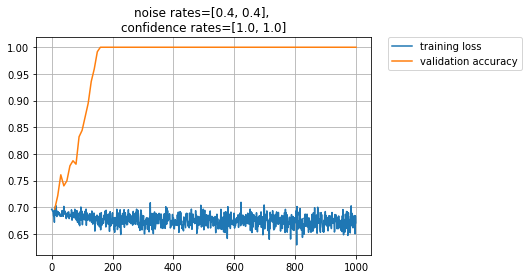

In [17]:
run(noise_rates=[.4, .4], confidence_rates=[1., 1.])

Ater 150 global steps, the validation accuracy reached 1.


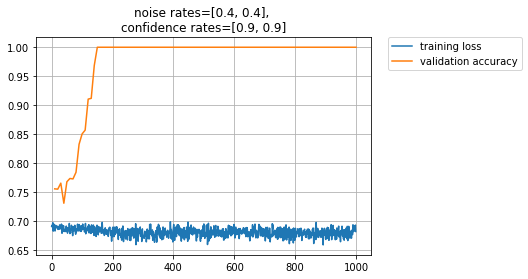

In [18]:
run(noise_rates=[.4, .4], confidence_rates=[.9, .9])

Ater 180 global steps, the validation accuracy reached 1.


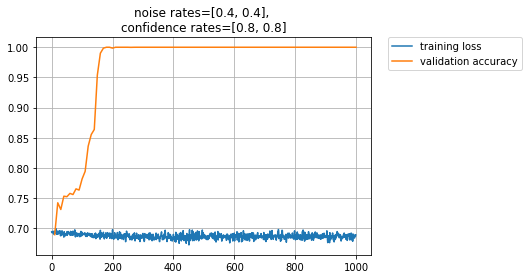

In [19]:
run(noise_rates=[.4, .4], confidence_rates=[.8, .8])

Ater 170 global steps, the validation accuracy reached 1.


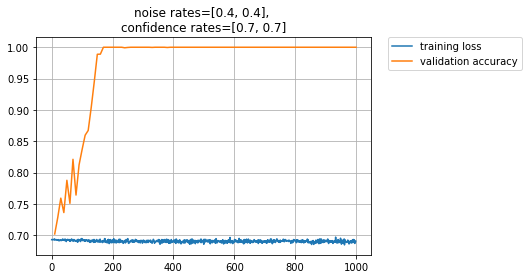

In [20]:
run(noise_rates=[.4, .4], confidence_rates=[.7, .7])

Ater 230 global steps, the validation accuracy reached 1.


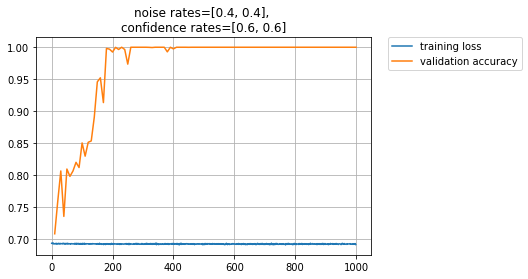

In [21]:
run(noise_rates=[.4, .4], confidence_rates=[.6, .6])

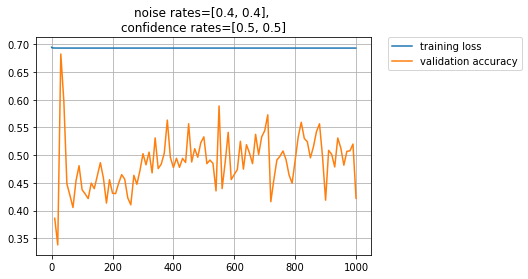

In [22]:
run(noise_rates=[.4, .4], confidence_rates=[.5, .5])

▴ Result: Not sure if label smoothing is helpful when there's noise in both labels.

# \#4. At this time, let's assume there's noise only in one label. We decrease the confidence rate solely for the noisy label by .1.

## What if the noise rate is .5?

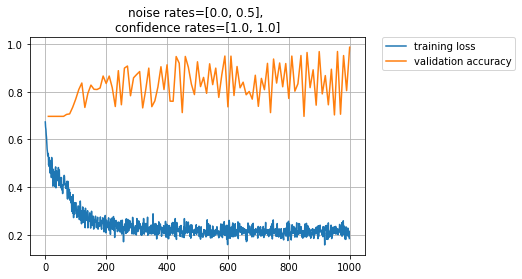

In [23]:
run(noise_rates=[0., .5], confidence_rates=[1., 1.])

Ater 470 global steps, the validation accuracy reached 1.


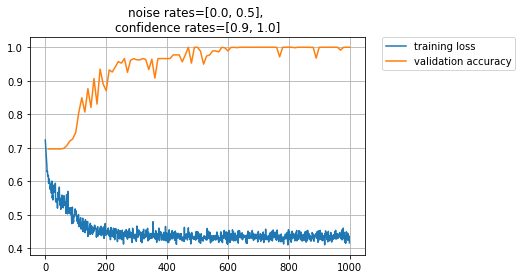

In [24]:
run(noise_rates=[0., .5], confidence_rates=[.9, 1.]) 
# Note that if the second label is noisy, the first label gets corrupted.

Ater 230 global steps, the validation accuracy reached 1.


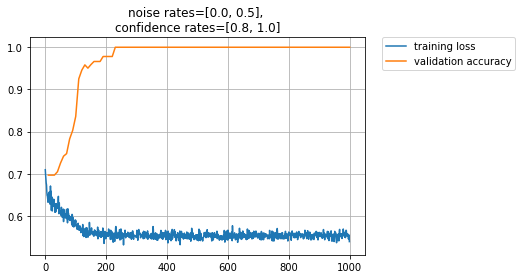

In [25]:
run(noise_rates=[0., .5], confidence_rates=[.8, 1.])

Ater 100 global steps, the validation accuracy reached 1.


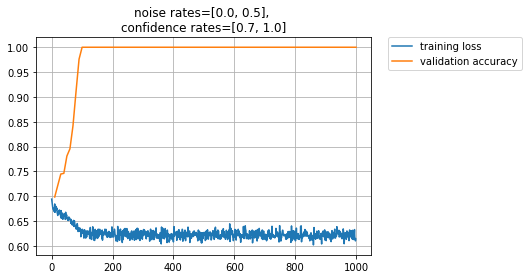

In [26]:
run(noise_rates=[0., .5], confidence_rates=[.7, 1.])

Ater 90 global steps, the validation accuracy reached 1.


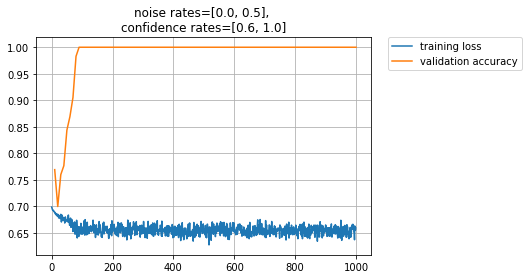

In [27]:
run(noise_rates=[0., .5], confidence_rates=[.6, 1.])

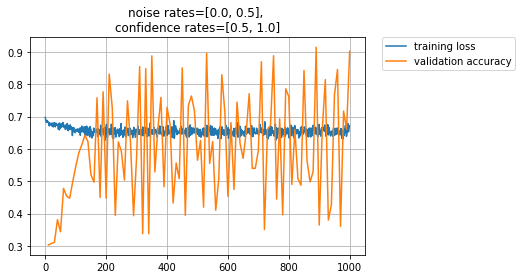

In [28]:
run(noise_rates=[0., .5], confidence_rates=[.5, 1.])

## What if the noise rate is .2?

Ater 160 global steps, the validation accuracy reached 1.


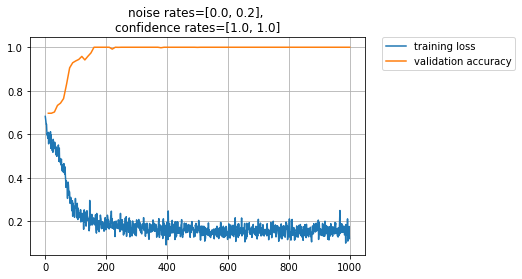

In [29]:
run(noise_rates=[0., .2], confidence_rates=[1., 1.])

Ater 110 global steps, the validation accuracy reached 1.


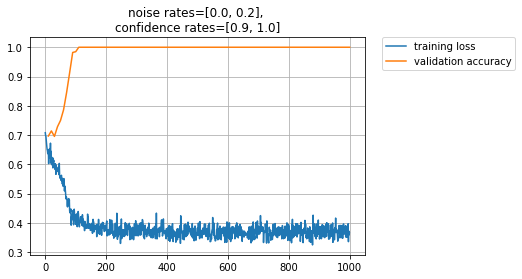

In [30]:
run(noise_rates=[0., .2], confidence_rates=[.9, 1.])

Ater 100 global steps, the validation accuracy reached 1.


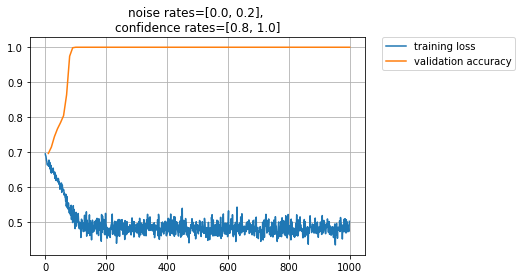

In [31]:
run(noise_rates=[0., .2], confidence_rates=[.8, 1.])

Ater 100 global steps, the validation accuracy reached 1.


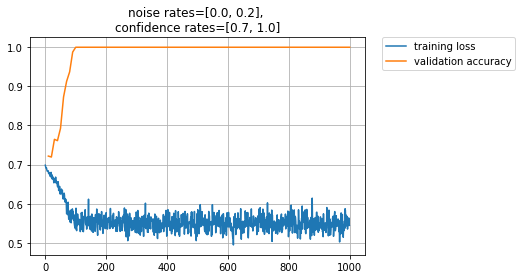

In [32]:
run(noise_rates=[0., .2], confidence_rates=[.7, 1.])

Ater 130 global steps, the validation accuracy reached 1.


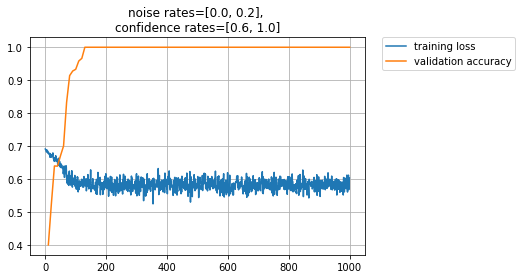

In [33]:
run(noise_rates=[0., .2], confidence_rates=[.6, 1.])

▴ Result: When there's noise in one label, label smoothing that approximates the noise rate can be helpful.